In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformation and Exploration.


This assignment asks you to predict readmission for diabetic patients admitted to hospital, i.e., what is the likelihood that a patient will need to come back to hospital given the data about this visit. 
This is based on a database of 101766 hospital visits with a set of 50 features covering patient information, treatment and prescribed medication during the hospital stay.
The database covers patients admitted to 130 hospitals in the US over a period of 10 years to 2008. The original data came from this source:

We decided to drop the following variables:

    'encounter_id',
    'patient_nbr',
    'diag_1',
    'diag_2',
    'diag_3', 
    'admission_source_id',
    'payer_code',

Intuitively, we can assume that all these datapoints have no incidence on the readmission because they are either abstract values arbitrarily set by humans (e.g. patinet_nbr) OR not directly related to the outcome of readmission (e.g. "admission_source_id).

    We have decided to keep 1)'admission_type_id' and 2)'discharge_disposition_id' though they could have been droped because 
    
    1) We assume that different hospitals are exhibiting different levels of healthcare services (some better than others) 
    
    2) We assume that being sent back home can exhibit higher chances of readmission than being transfered to another hospital, in which patients are constantly monitored. 


In [2]:
df_train = pd.read_csv("Dataset/diabetic_data_training.csv")
df_test = pd.read_csv('Dataset/diabetic_data_test.csv')

print(df_train.head(5))
print(df_test.head(5))

   encounter_id  patient_nbr             race  gender      age weight  \
0        149190     55629189        Caucasian  Female  [10-20)      ?   
1         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
2        500364     82442376        Caucasian    Male  [30-40)      ?   
3         16680     42519267        Caucasian    Male  [40-50)      ?   
4         35754     82637451        Caucasian    Male  [50-60)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  1                         1                    7   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  2                         1                    2   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 3  ...          No      Up                   No

We assigned textual values to the numerical placeholders in the dataset communicated as we might perform some NLP

In [3]:
mapping_csv = pd.read_csv("Dataset/IDS_mapping.csv")
mapping_csv = mapping_csv.dropna(how='all')
dictionaries = {}
current_dict = 'admission_type_id'
dictionaries[current_dict] = {}


for index, row in mapping_csv.iterrows():
   id = row.to_list()[0]
   if id.isdigit():
       dictionaries[current_dict][row.to_list()[0]] = str(row.to_list()[1])
   else:
       current_dict = id
       dictionaries[current_dict] = {}

In [4]:
if 'admission_type_id' in df_train.columns:
   df_train['admission_type_id'] = df_train['admission_type_id'].astype(str).map(dictionaries['admission_type_id'])


# Map discharge dispositions
if 'discharge_disposition_id' in df_train.columns:
   df_train['discharge_disposition_id'] = df_train['discharge_disposition_id'].astype(str).map(dictionaries['discharge_disposition_id'])


if 'admission_source_id' in df_train.columns:
   df_train['admission_source_id'] = df_train['admission_source_id'].astype(str).map(dictionaries['admission_source_id'])


df_train.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,Emergency,Discharged to home,Emergency Room,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,Emergency,Discharged to home,Emergency Room,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,Emergency,Discharged to home,Emergency Room,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,Emergency,Discharged to home,Emergency Room,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,Urgent,Discharged to home,Clinic Referral,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
5,55842,84259809,Caucasian,Male,[60-70),?,Elective,Discharged to home,Clinic Referral,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,63768,114882984,Caucasian,Male,[70-80),?,Emergency,Discharged to home,Emergency Room,5,...,No,No,No,No,No,No,No,No,Yes,>30
7,12522,48330783,Caucasian,Female,[80-90),?,Urgent,Discharged to home,Transfer from a hospital,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
8,15738,63555939,Caucasian,Female,[90-100),?,Elective,Discharged/transferred to SNF,Transfer from a hospital,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,36900,77391171,AfricanAmerican,Male,[60-70),?,Urgent,Discharged to home,Transfer from a hospital,7,...,No,Steady,No,No,No,No,No,Ch,Yes,<30


In [5]:
# Columns to drop
features_to_drop = ['encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3', 'admission_source_id', 'payer_code']

print(df_train.columns)

print("Number of columns in df_train before dropping:", len(df_train.columns))

# # Drop columns directly from both dataframes
df_train = df_train.drop(columns=features_to_drop, axis=1)
df_test = df_test.drop(columns=features_to_drop, axis=1)

# Print the number of columns remaining
print("Number of columns in df_train after dropping:", len(df_train.columns))

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
Number of columns in df_train before dropping: 50
Number of columns i

In [6]:
# 1. Basic Summary Statistics
print("Summary Statistics:")
df_train.describe(include='all')

Summary Statistics:


,race,gender,age,weight,admission_type_id,discharge_disposition_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,91589,91589,91589,91589,91589,91589,91589.000000,91589,91589.000000,91589.000000,...,91589,91589,91589,91589,91589,91589,91589,91589,91589,91589
unique,6,3,10,10,8,26,NaN,73,NaN,NaN,...,1,4,4,2,1,2,2,2,2,3
top,Caucasian,Female,[70-80),?,Emergency,Discharged to home,NaN,?,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,68478,49217,23452,88754,48612,54187,NaN,44992,NaN,NaN,...,91589,42539,90963,91576,91589,91588,91588,49235,70555,49355
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.395550,NaN,43.079180,1.337846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,2.987944,NaN,19.676827,1.704700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,31.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,44.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,57.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Checking for Missing Values and Printing Only Features with Missing Values
missing_values = df_train.isnull().sum()

# Filter for features with missing values
missing_features = missing_values[missing_values > 0]

# Print the features with missing values
print("\nFeatures with Missing Values:")
print(missing_features)


Features with Missing Values:
max_glu_serum    86793
A1Cresult        76282
dtype: int64


As we can see, two of our dataset features habe a large number of missing values. These are:

max_glu_serum: 

A1Cresult: 

In [7]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


ValueError: could not convert string to float: 'Caucasian'

<Figure size 1200x800 with 0 Axes>

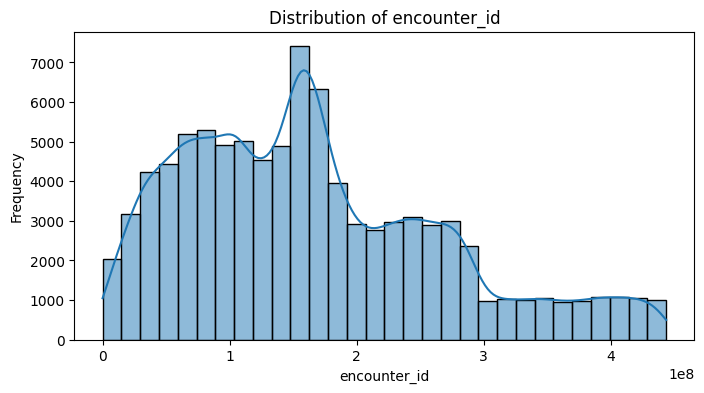

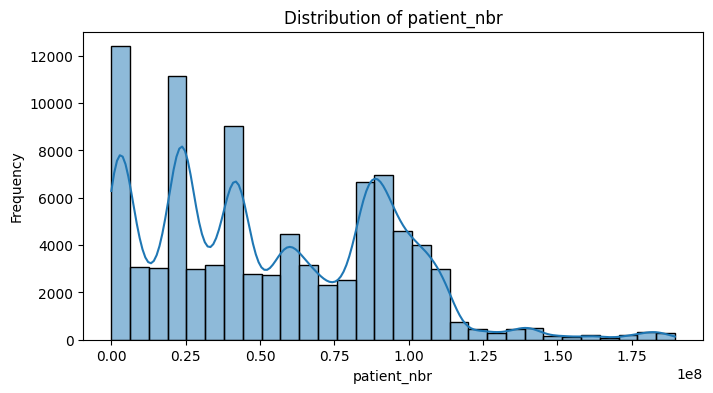

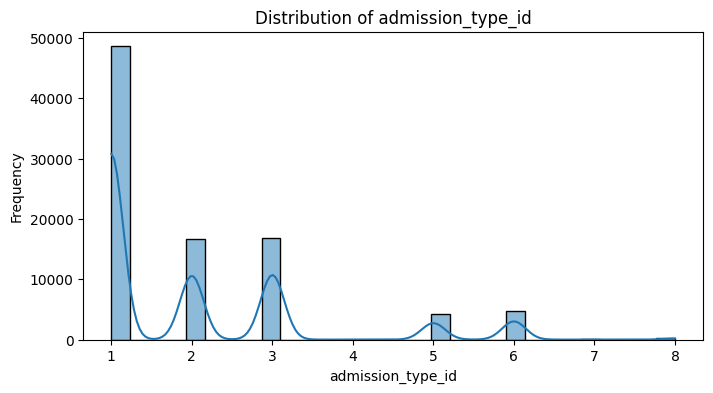

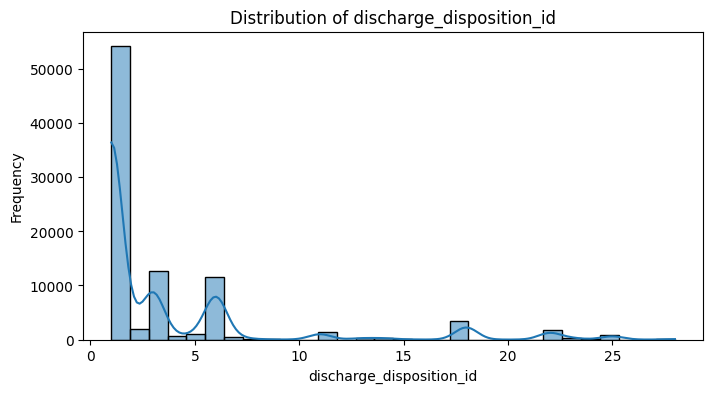

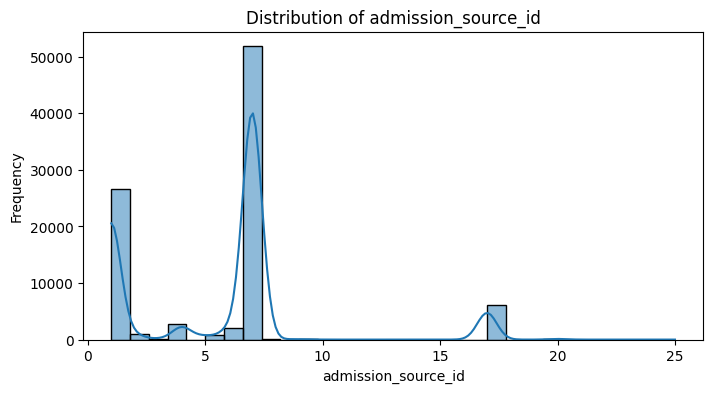

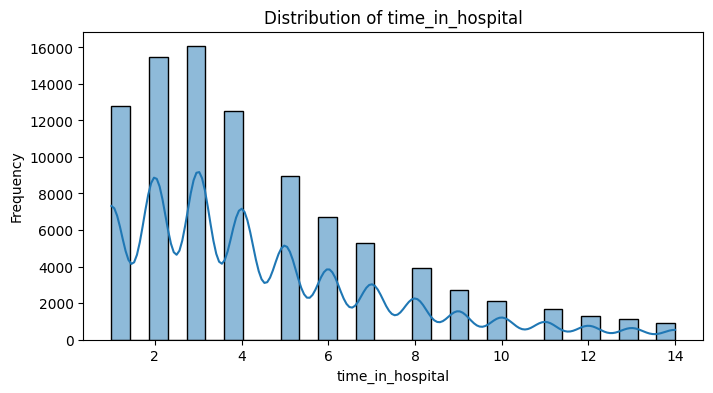

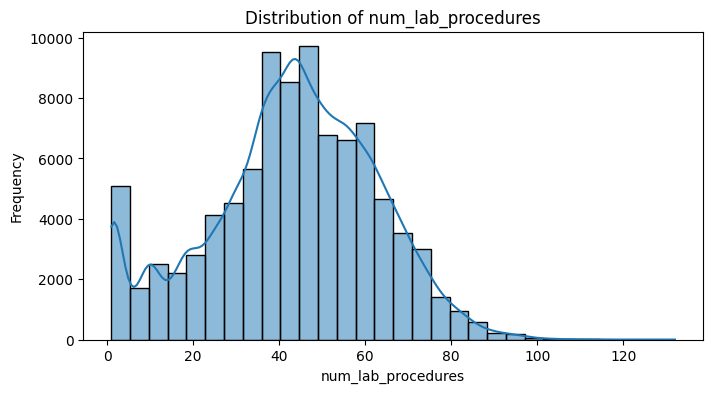

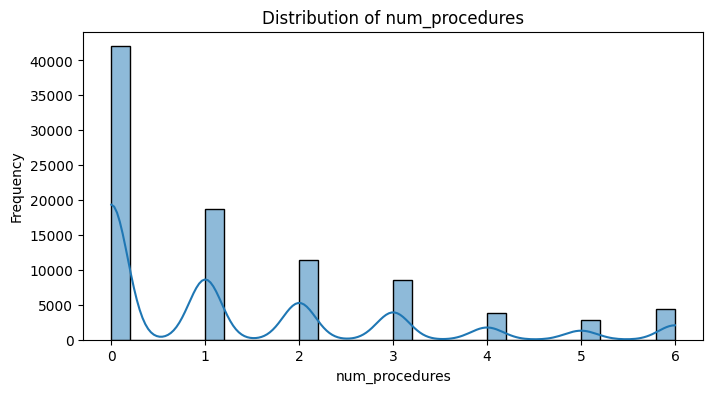

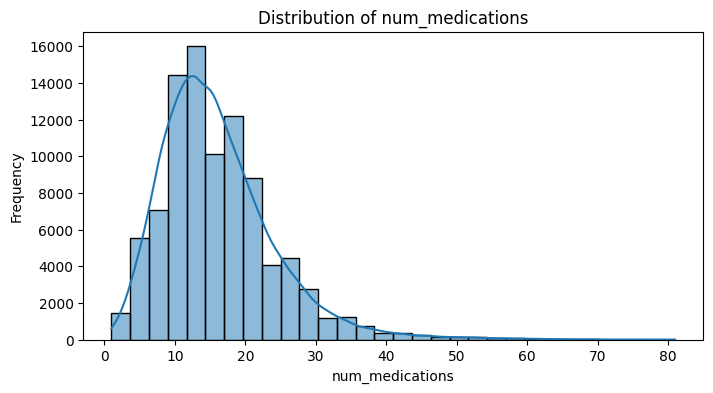

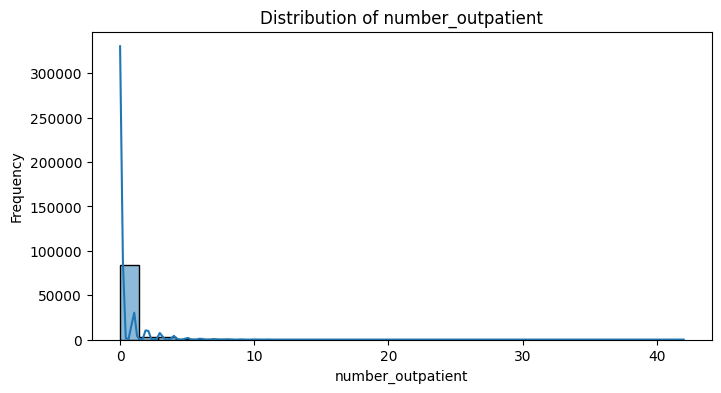

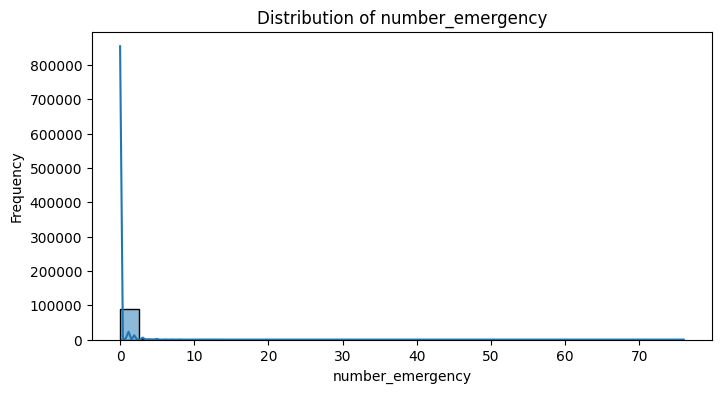

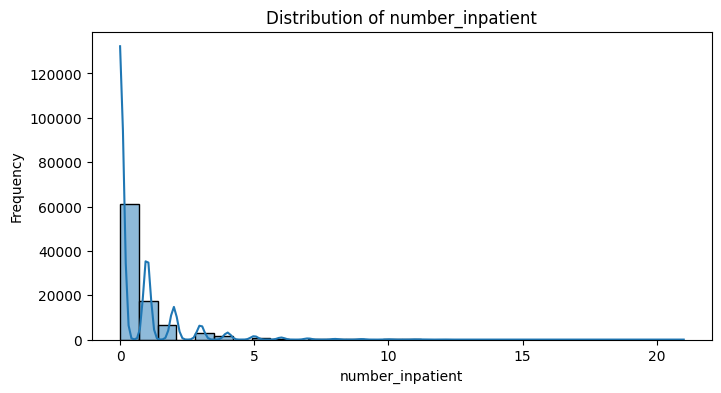

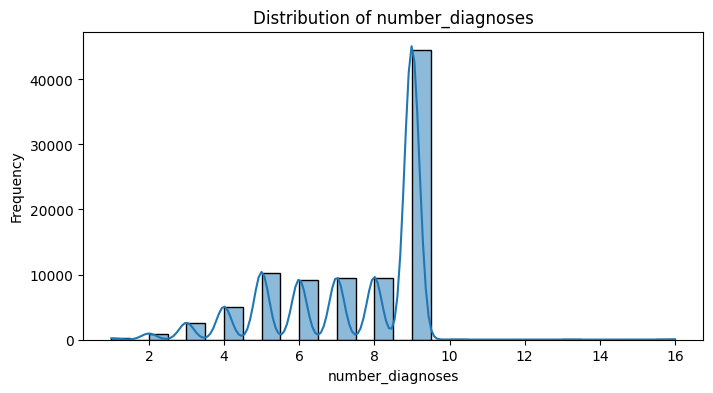

In [7]:
# 4. Distribution of Numerical Features
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

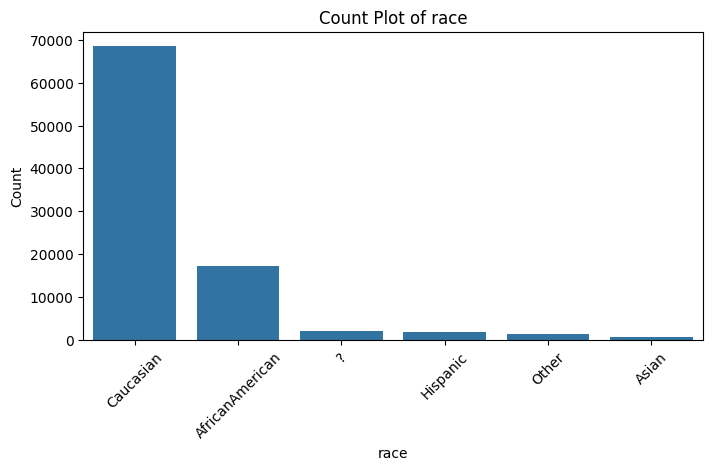

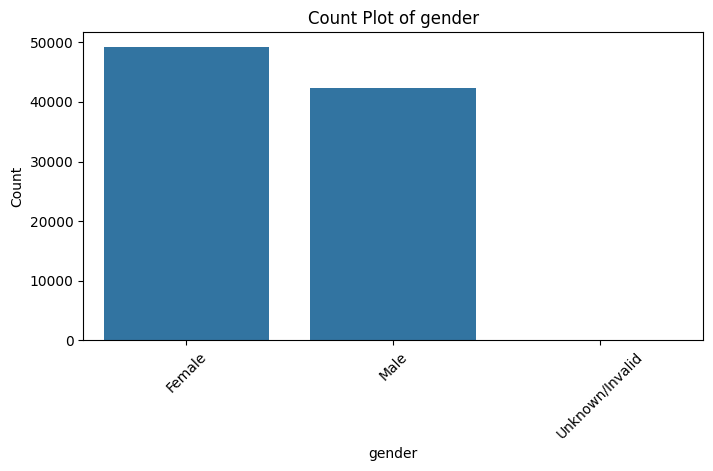

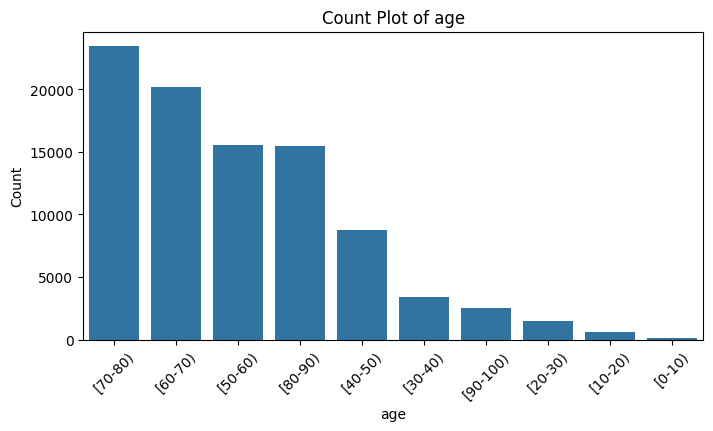

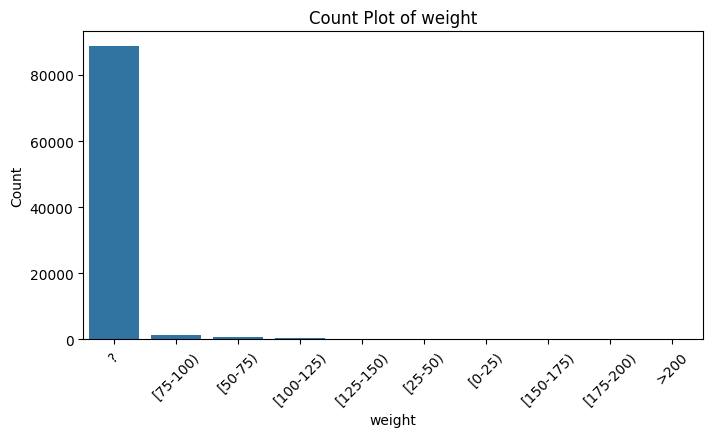

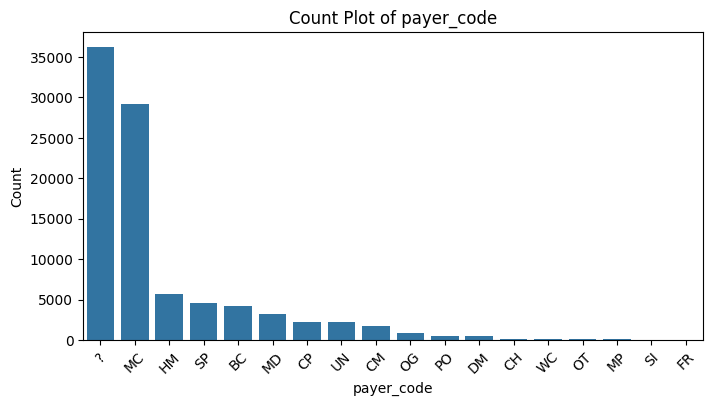

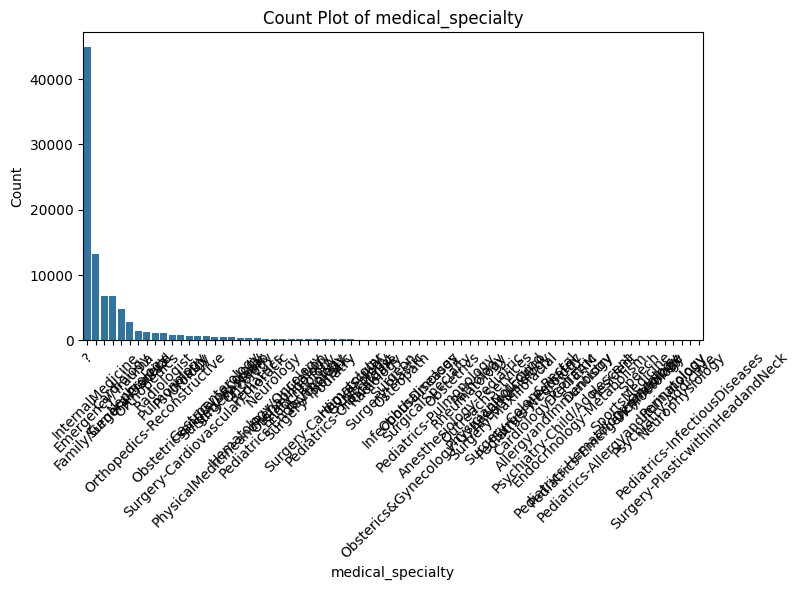

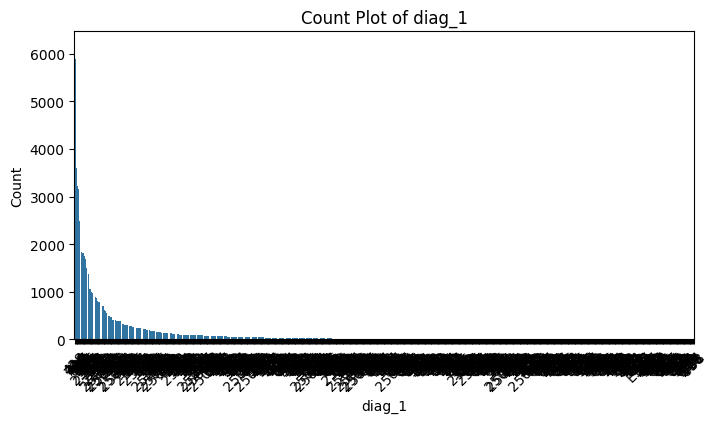

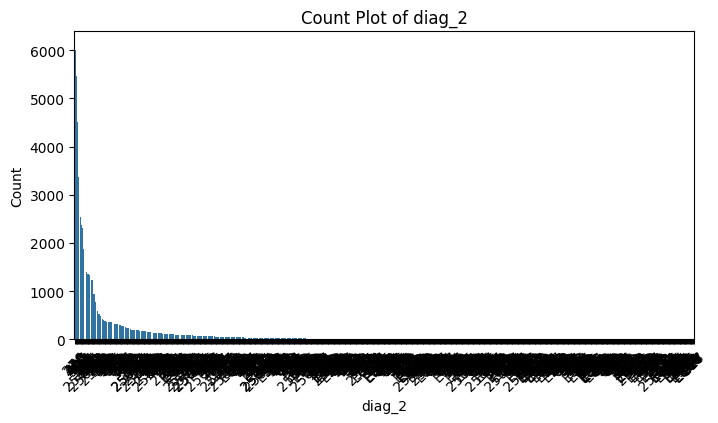

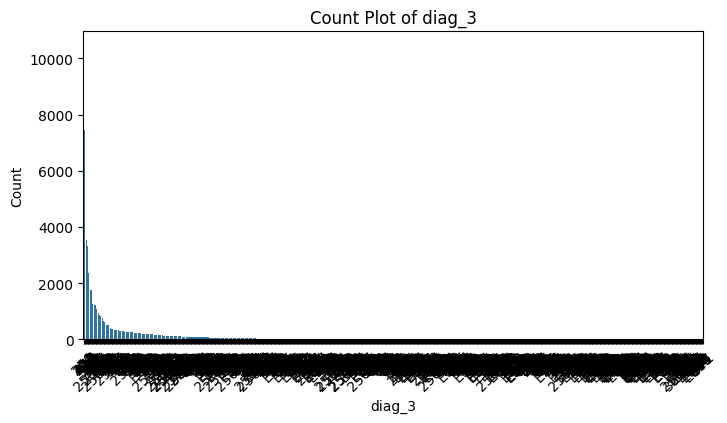

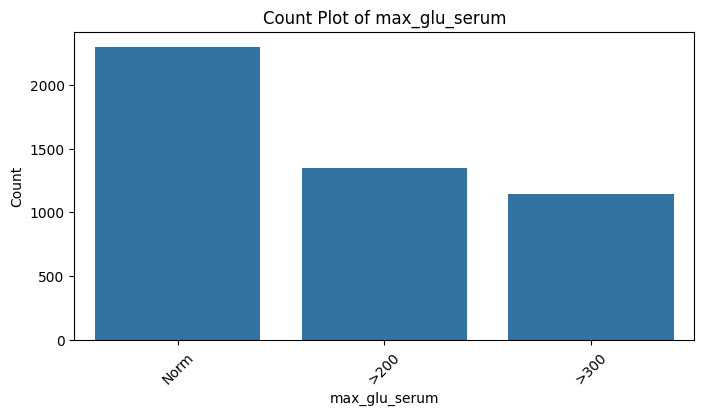

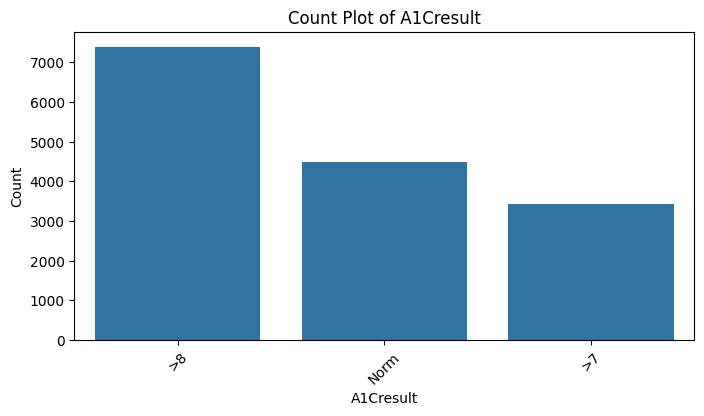

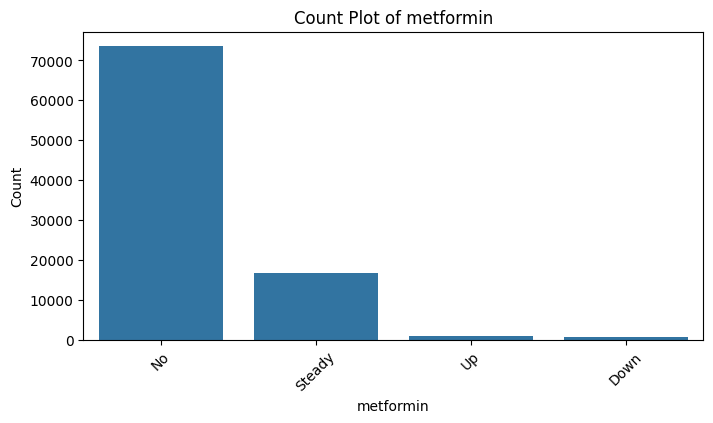

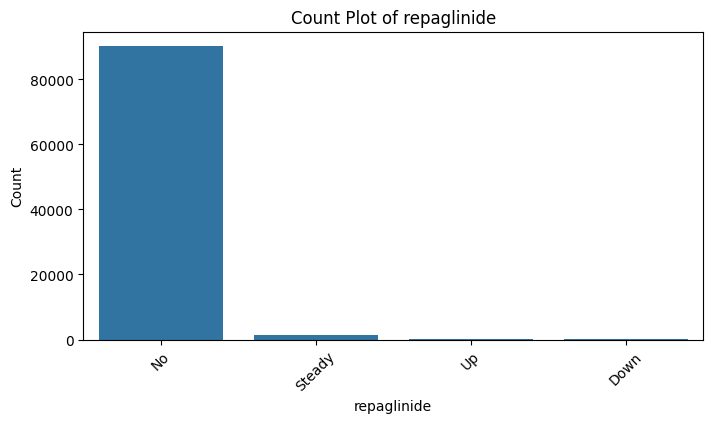

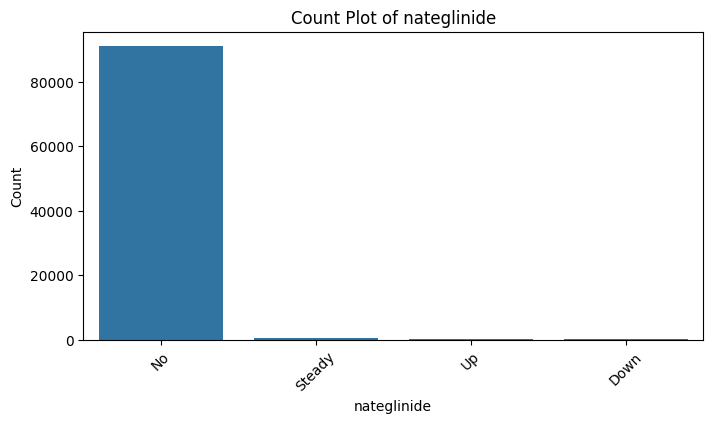

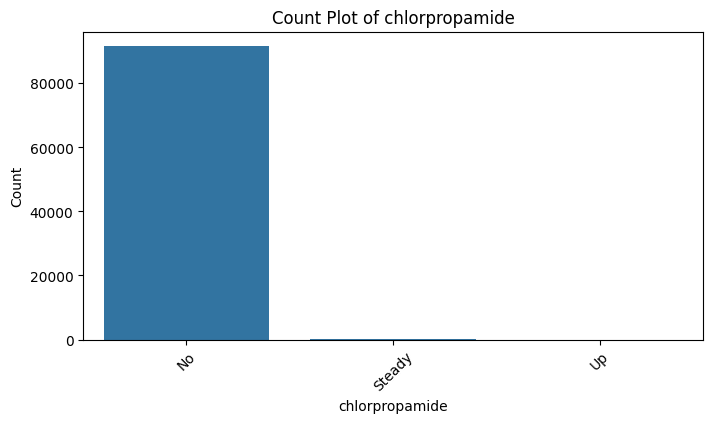

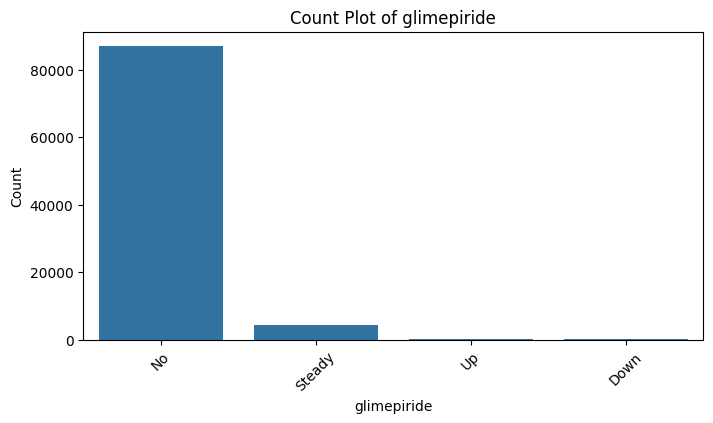

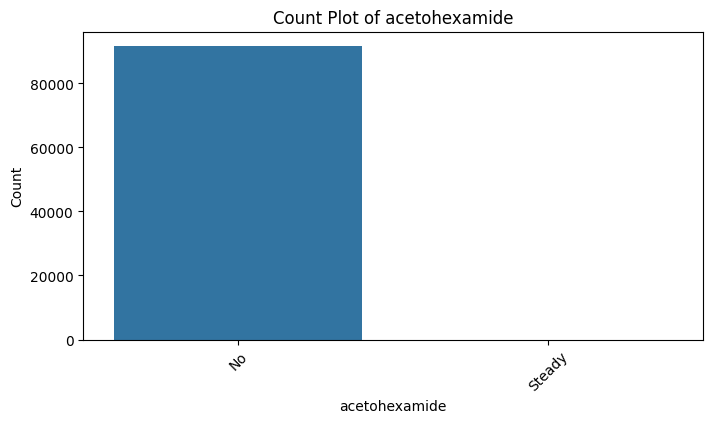

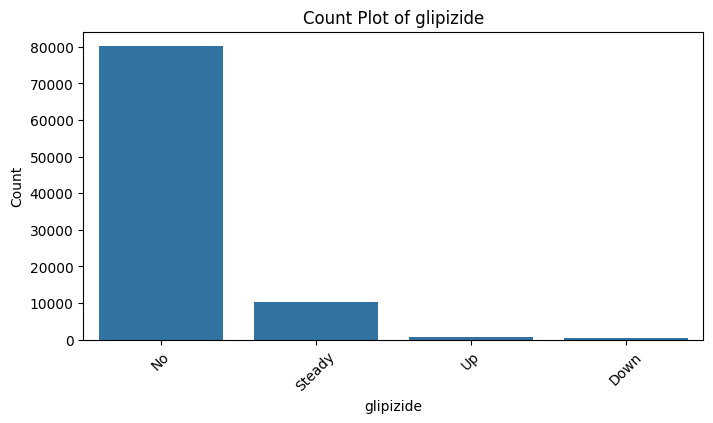

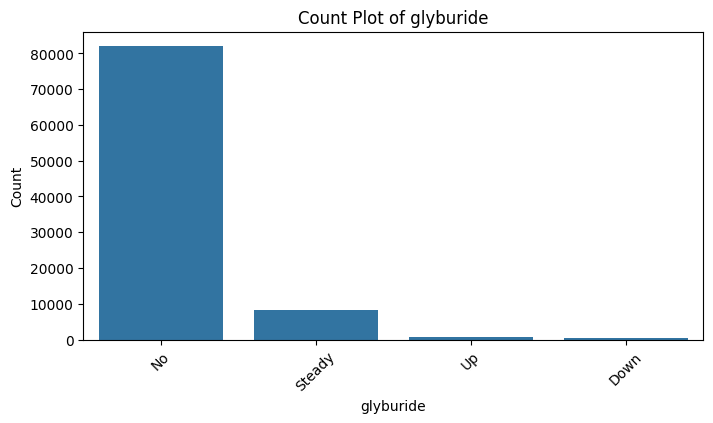

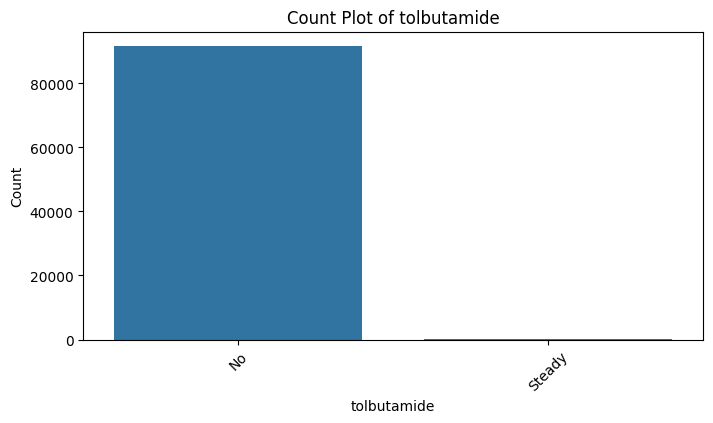

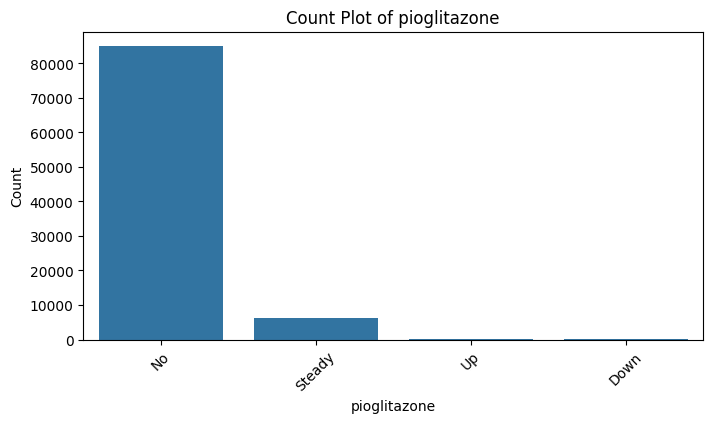

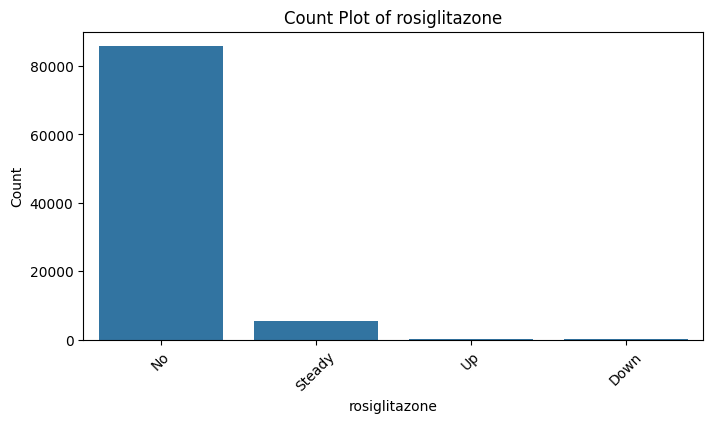

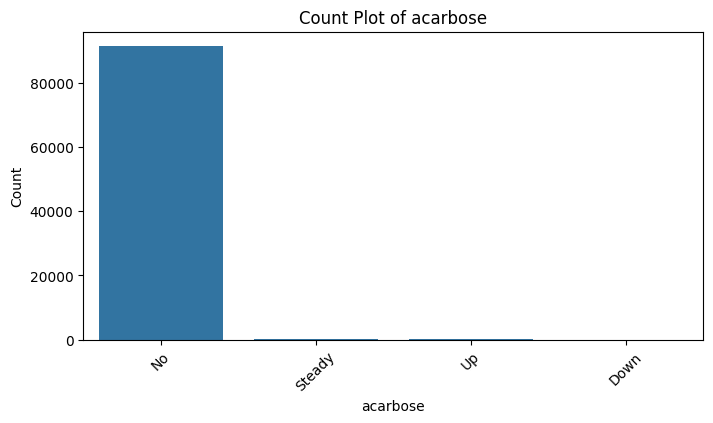

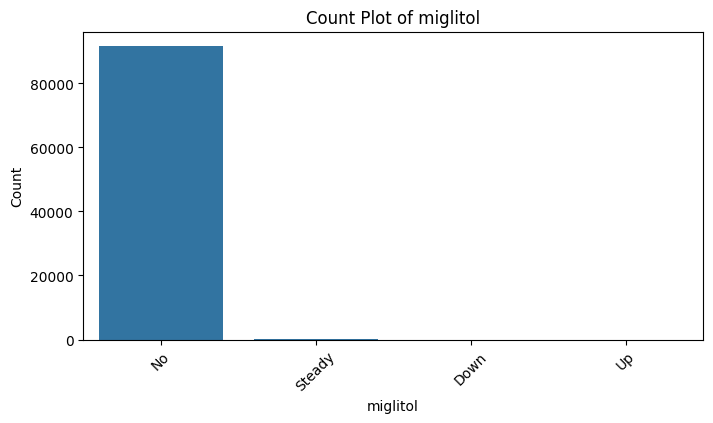

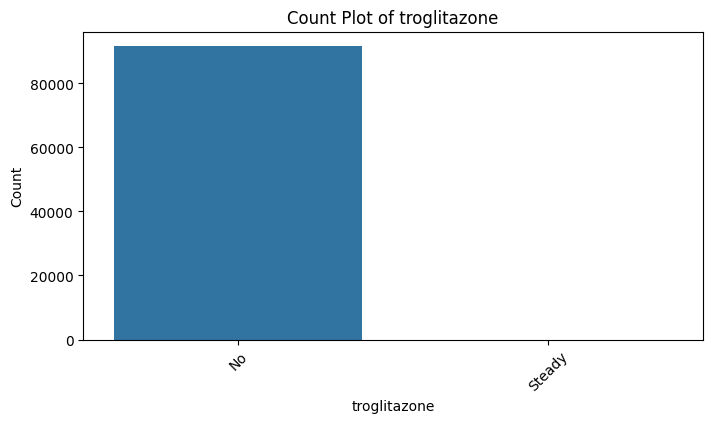

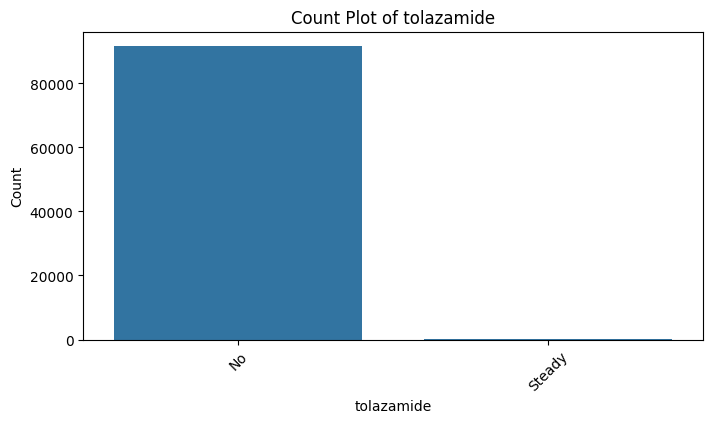

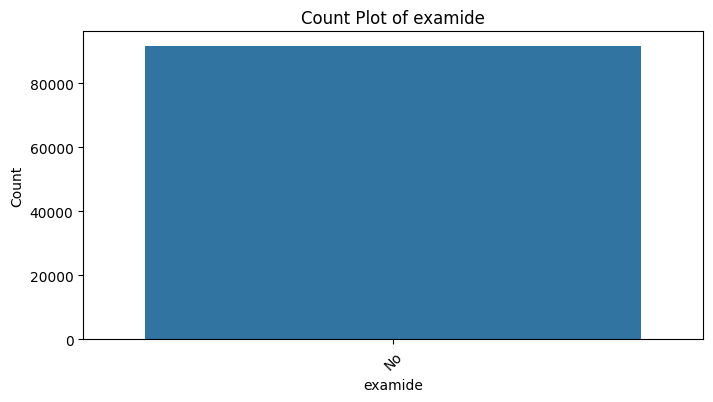

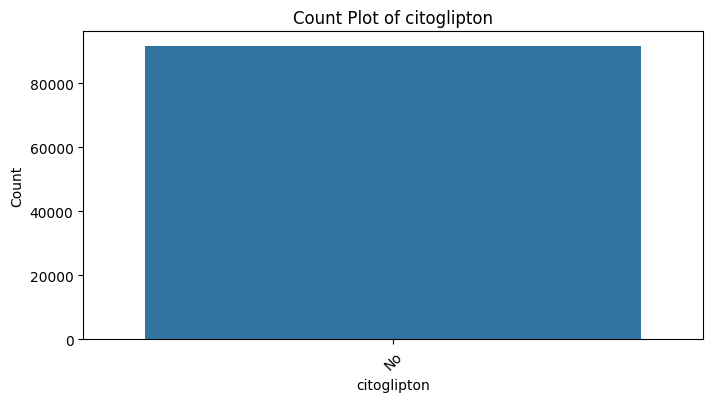

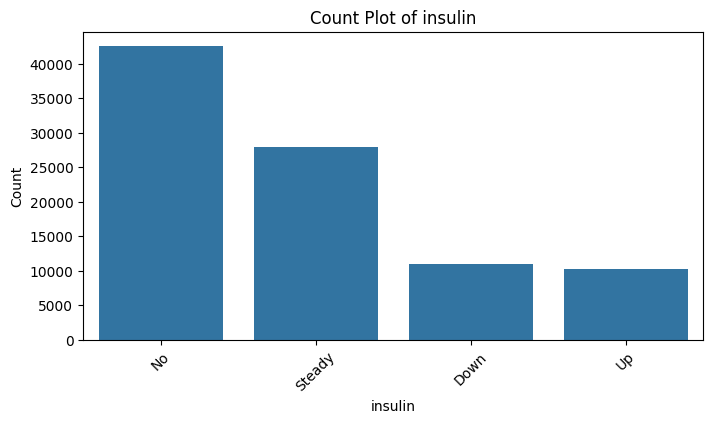

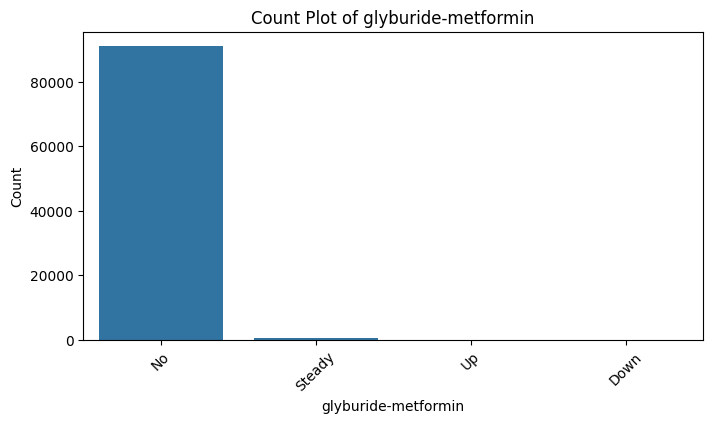

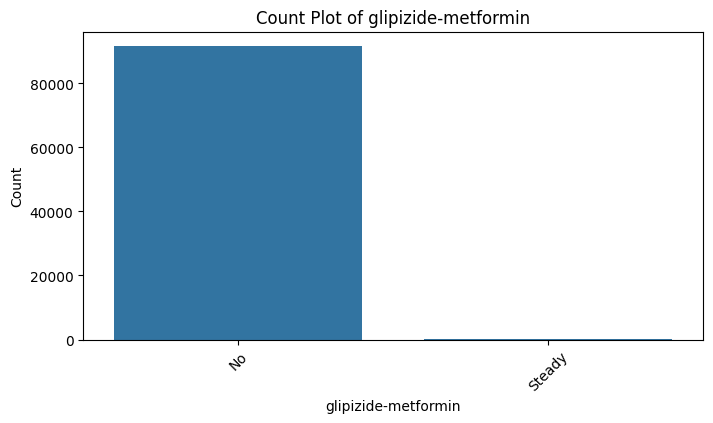

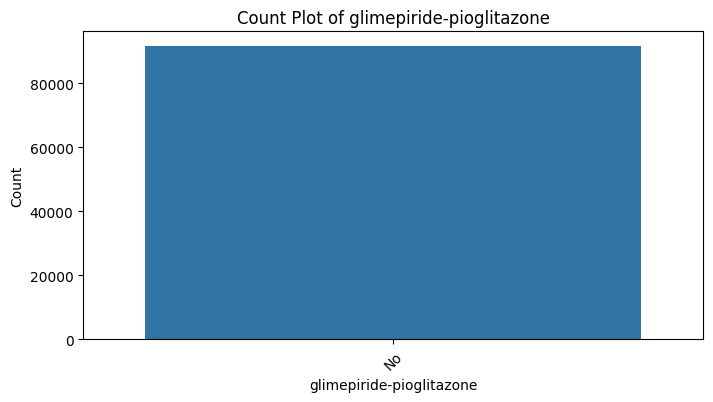

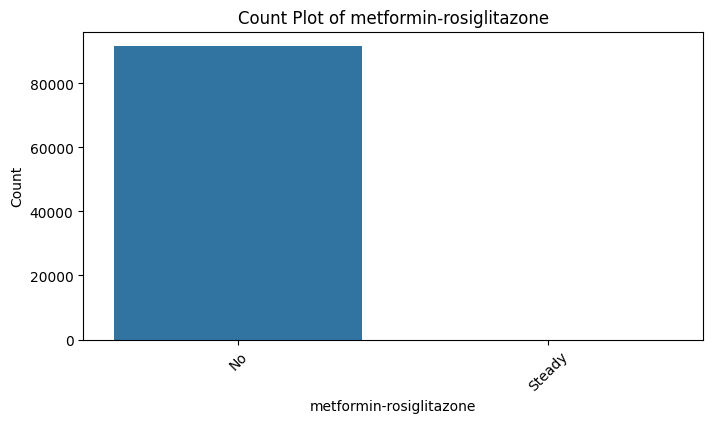

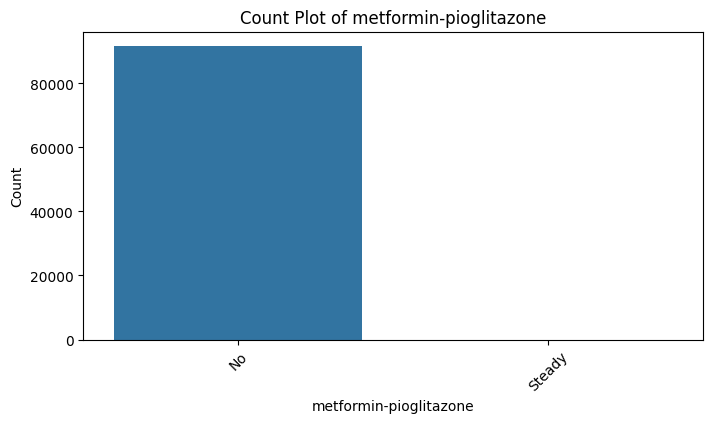

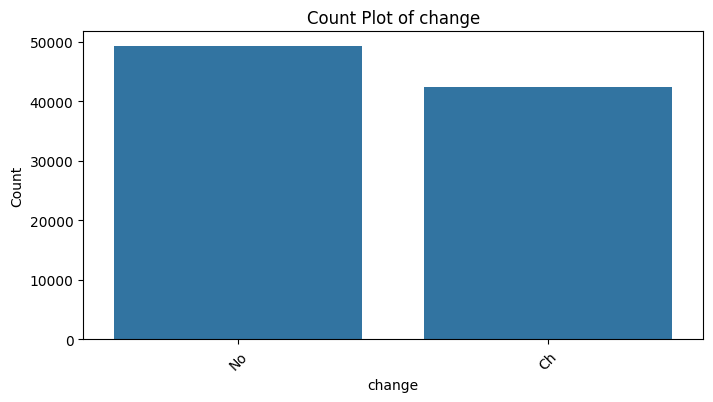

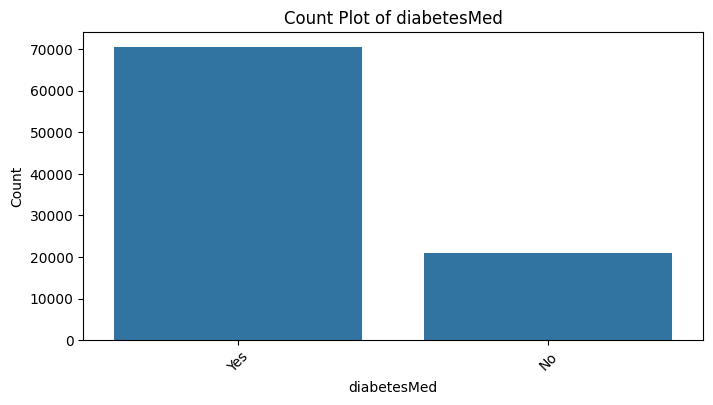

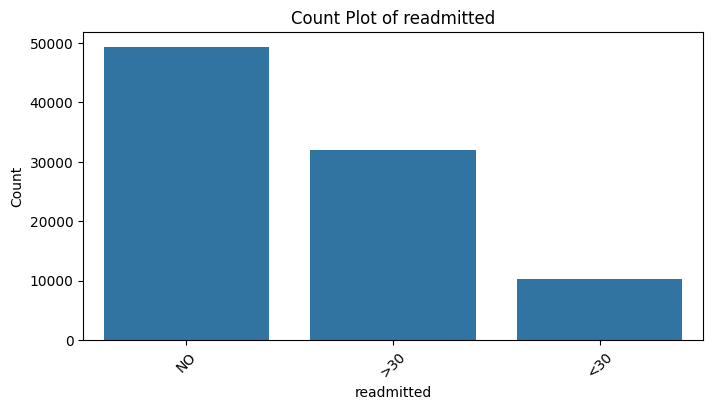

In [8]:
# 5. Count Plots for Categorical Features
categorical_features = df_train.select_dtypes(include=['object']).columns

for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index)
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


In [9]:
# 7. Correlation with Target Variable 

if 'readmitted' in df_train.columns:
    target_correlation = df_train.corr()['readmitted'].sort_values(ascending=False)
    print("\nCorrelation with Target Variable:")
    print(target_correlation)
    
# PLOT A HEATMAP??

ValueError: could not convert string to float: 'Caucasian'